# Representation Learning


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import glob
from datetime import datetime
import math
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

### Q3.1 Pretraining and Linear Probes (4 pts)

### Used transformer architecture similar to Q2.2 implementation

In [2]:
from torch.utils.data import DataLoader, Dataset
class PatientDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [3]:
# Loading data while also respecting time parameter. (Note that i removed MechVent, so that we have 40 parameters
# => much easier to define num_heads in the transformer architecture that way. Also, MechVent is not that important of a parameter)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
batch_size = 64

# Training Data
df = pd.read_parquet('final-data/final-set-a.parquet')
X_a = df.fillna(0)
X_a = X_a.groupby("RecordID").tail(49).reset_index(drop=True)
X_a = X_a.sort_values(by="RecordID", ascending=True)
X_a["Time"] = scaler.fit_transform(X_a[["Time"]])
X_a = X_a.drop(columns=["RecordID"]).drop(columns=["MechVent"])
X_a = X_a[sorted(X_a.columns)]
X_a = X_a.to_numpy()
X_a = X_a.reshape(4000,49,40)

train_dataset = PatientDataset(X_a, X_a)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Validation data
df = pd.read_parquet('final-data/final-set-b.parquet')
X_b = df.fillna(0)
X_b = X_b.groupby("RecordID").tail(49).reset_index(drop=True)
X_b = X_b.sort_values(by="RecordID", ascending=True)
X_b["Time"] = scaler.fit_transform(X_b[["Time"]])
X_b = X_b.drop(columns=["RecordID"]).drop(columns=["ICUType"]).drop(columns=["MechVent"])
X_b = X_b[sorted(X_b.columns)]
X_b = X_b.to_numpy()
X_b = X_b.reshape(4000,49,40)

val_dataset = PatientDataset(X_b, X_b)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


# Test data
df = pd.read_parquet('final-data/final-set-c.parquet')
X_c = df.fillna(0)
X_c = X_c.groupby("RecordID").tail(49).reset_index(drop=True)
X_c = X_c.sort_values(by="RecordID", ascending=True)
X_c["Time"] = scaler.fit_transform(X_c[["Time"]])
X_c = X_c.drop(columns=["RecordID"]).drop(columns=["ICUType"]).drop(columns=["MechVent"])
X_c = X_c[sorted(X_c.columns)]
X_c = X_c.to_numpy()
X_c = X_c.reshape(4000,49,40)

test_dataset = PatientDataset(X_c, X_c)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Transformer from Q2.3a without FC layer for classification

class TransformerEncoder(nn.Module):
    def __init__(self, input_size=40, latent_dim=16, seq_length=49, num_heads=4, num_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        self.embedding = nn.Linear(input_size, latent_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=latent_dim,  # Dimensionality of the embeddings
            nhead=num_heads, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        
        # Stacking multiple transformer layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return x

In [5]:
# Decoder to decode latent space data to original space

class TransformerDecoder(nn.Module):
    def __init__(self, output_dim=40, latent_dim=16, num_heads=4, dim_feedforward=128, num_layers=3):
        super(TransformerDecoder, self).__init__()

        self.input_layer = nn.Linear(latent_dim, latent_dim)
        self.output_layer = nn.Linear(latent_dim, output_dim)
        
        # Use latent_dim for the decoder layers
        decoder_layers = nn.TransformerDecoderLayer(d_model=latent_dim, nhead=num_heads, dim_feedforward=dim_feedforward, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layers, num_layers=num_layers)
        
    def forward(self, latent, memory=None):
        x_reconstructed = self.input_layer(latent)  # Project back to latent_dim
        x_reconstructed = self.decoder(x_reconstructed, memory)  # Transformer decoder
        x_reconstructed = self.output_layer(x_reconstructed)  # Project back to original input_dim (output_dim)
        return x_reconstructed

In [6]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=40, seq_length=49, latent_dim=16, num_heads=4, dim_feedforward=128, num_layers=3):
        super(TransformerAutoencoder, self).__init__()
        self.encoder = TransformerEncoder(input_dim, latent_dim=latent_dim, seq_length=seq_length, num_heads=num_heads, num_layers=num_layers, dim_feedforward=dim_feedforward)
        self.decoder = TransformerDecoder(output_dim=input_dim, latent_dim=latent_dim, num_heads=num_heads, num_layers=num_layers, dim_feedforward=dim_feedforward)
    
    def forward(self, x):
        latent = self.encoder(x)  # Get the latent representation from the encoder
        x_reconstructed = self.decoder(latent, latent)  # Pass latent to the decoder
        return x_reconstructed, latent

100%|██████████| 63/63 [00:01<00:00, 36.35it/s]


Epoch 1/25, Train Loss: 0.673712, Val Loss: 0.853768


100%|██████████| 63/63 [00:01<00:00, 34.61it/s]


Epoch 2/25, Train Loss: 0.538097, Val Loss: 0.765586


100%|██████████| 63/63 [00:01<00:00, 36.09it/s]


Epoch 3/25, Train Loss: 0.467082, Val Loss: 0.707836


100%|██████████| 63/63 [00:01<00:00, 35.45it/s]


Epoch 4/25, Train Loss: 0.420720, Val Loss: 0.666161


100%|██████████| 63/63 [00:01<00:00, 36.47it/s]


Epoch 5/25, Train Loss: 0.383019, Val Loss: 0.636700


100%|██████████| 63/63 [00:01<00:00, 38.40it/s]


Epoch 6/25, Train Loss: 0.358346, Val Loss: 0.615349


100%|██████████| 63/63 [00:01<00:00, 33.00it/s]


Epoch 7/25, Train Loss: 0.339770, Val Loss: 0.598480


100%|██████████| 63/63 [00:01<00:00, 37.28it/s]


Epoch 8/25, Train Loss: 0.321503, Val Loss: 0.582535


100%|██████████| 63/63 [00:01<00:00, 39.01it/s]


Epoch 9/25, Train Loss: 0.305856, Val Loss: 0.569228


100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 10/25, Train Loss: 0.294408, Val Loss: 0.557547


100%|██████████| 63/63 [00:01<00:00, 40.23it/s]


Epoch 11/25, Train Loss: 0.280943, Val Loss: 0.547107


100%|██████████| 63/63 [00:01<00:00, 39.88it/s]


Epoch 12/25, Train Loss: 0.271156, Val Loss: 0.540985


100%|██████████| 63/63 [00:01<00:00, 36.87it/s]


Epoch 13/25, Train Loss: 0.264686, Val Loss: 0.535530


100%|██████████| 63/63 [00:01<00:00, 37.63it/s]


Epoch 14/25, Train Loss: 0.259878, Val Loss: 0.532167


100%|██████████| 63/63 [00:01<00:00, 37.57it/s]


Epoch 15/25, Train Loss: 0.256603, Val Loss: 0.529052


100%|██████████| 63/63 [00:01<00:00, 38.22it/s]


Epoch 16/25, Train Loss: 0.252749, Val Loss: 0.526709


100%|██████████| 63/63 [00:01<00:00, 38.09it/s]


Epoch 17/25, Train Loss: 0.250361, Val Loss: 0.524554


100%|██████████| 63/63 [00:01<00:00, 37.07it/s]


Epoch 18/25, Train Loss: 0.248159, Val Loss: 0.523262


100%|██████████| 63/63 [00:01<00:00, 37.86it/s]


Epoch 19/25, Train Loss: 0.248031, Val Loss: 0.523412


100%|██████████| 63/63 [00:01<00:00, 36.58it/s]


Epoch 20/25, Train Loss: 0.244504, Val Loss: 0.520512


100%|██████████| 63/63 [00:01<00:00, 38.53it/s]


Epoch 21/25, Train Loss: 0.244152, Val Loss: 0.519333


100%|██████████| 63/63 [00:01<00:00, 36.95it/s]


Epoch 22/25, Train Loss: 0.242755, Val Loss: 0.519150


100%|██████████| 63/63 [00:01<00:00, 37.12it/s]


Epoch 23/25, Train Loss: 0.240991, Val Loss: 0.517642


100%|██████████| 63/63 [00:01<00:00, 37.80it/s]


Epoch 24/25, Train Loss: 0.239656, Val Loss: 0.516890


100%|██████████| 63/63 [00:01<00:00, 38.77it/s]


Epoch 25/25, Train Loss: 0.238682, Val Loss: 0.515891


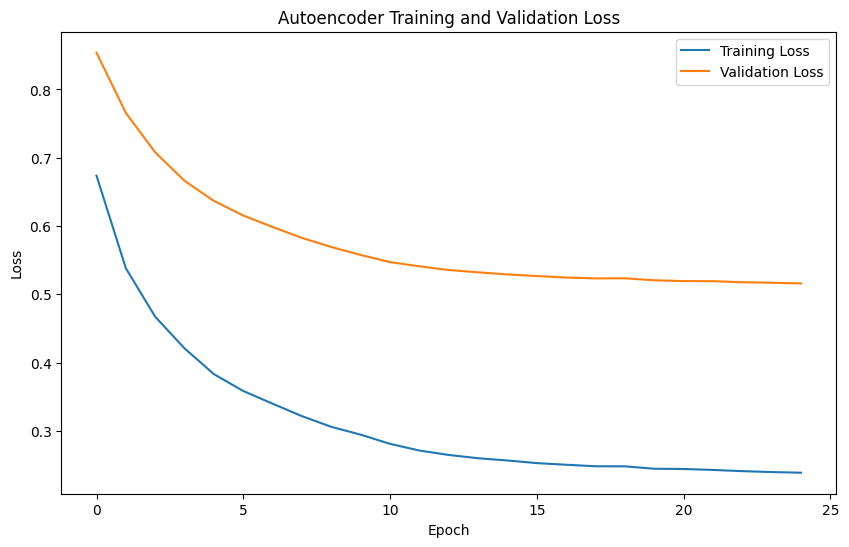

<All keys matched successfully>

In [8]:
# Initialize model and optimization
hidden_dim = 128
embedding_dim = 20
autoencoder = TransformerAutoencoder()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = autoencoder.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 25
train_losses = []
val_losses = []

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0


for epoch in range(num_epochs):
    # Training
    autoencoder.train()
    epoch_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        
        # Forward pass
        reconstructed, _ = autoencoder(data)
        loss = criterion(reconstructed, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    autoencoder.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            reconstructed, _ = autoencoder(data)
            loss = criterion(reconstructed, data)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(autoencoder.state_dict(), 'embedding_autoencoder/best_autoencoder.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.savefig('embedding_autoencoder/autoencoder_loss.png')
plt.show()

# Load the best model
autoencoder.load_state_dict(torch.load('embedding_autoencoder/best_autoencoder.pth'))

### Linear Probe

In [9]:
# Takes input data as tensor and returns embeddings (e.g., 4000x49x40 => 4000x16)
def create_embeddings(input_data, model, device='cuda'):
    model.eval()
    input_data = input_data.to(device)  # Move input data to device
    with torch.no_grad():  # No need to compute gradients during inference
        latent_embeddings = model.encoder(input_data)  # Pass input through the encoder
    
    # You can perform pooling (e.g., mean) over the sequence length dimension if needed
    # For example, average the embeddings over the sequence length
    embeddings = latent_embeddings.mean(dim=1)  # Shape: [batch_size, latent_dim]
    
    return embeddings

In [10]:
# Take embeddings and load labels
X_a_tensor = torch.tensor(X_a, dtype=torch.float32)
X = create_embeddings(X_a_tensor, autoencoder)
y_df = pd.read_parquet('processed-data/processed-outcomes-a.parquet')
y = y_df["In-hospital_death"].to_numpy().flatten()

In [11]:
# Perform Logistic Regression (not really finetuned as of now)
X = X.cpu()
model1 = LogisticRegression(max_iter=500, class_weight='balanced')
model1.fit(X,y)

LogisticRegression(class_weight='balanced', max_iter=500)

In [12]:
# Loading test set C
X_c_tensor = torch.tensor(X_c, dtype=torch.float32)
X = create_embeddings(X_c_tensor, autoencoder)
X = X.cpu()
y_df = pd.read_parquet('processed-data/processed-outcomes-c.parquet')
y_test = y_df["In-hospital_death"].to_numpy().flatten()

y_pred1 = model1.predict_proba(X)[:,1]

# Calculation of AuROC and AuPRC for Logistic Regression
print("Logistic Regression results")
auroc = roc_auc_score(y_test, y_pred1)
print(f"AUROC: {auroc}")
auprc = average_precision_score(y_test, y_pred1)
print(f"AUPRC: {auprc}", end="\n\n")

Logistic Regression results
AUROC: 0.8104160878977863
AUPRC: 0.4489287359617922

